# Chapter 5 - Classification

Import required Python packages.

In [4]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
LOAN3000_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\loan3000.csv"
LOAN_DATA_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\loan_data.csv"
FULL_TRAIN_SET_CSV = r"\Personal\Full_Stack_Data_Analyst\Data_Science\O-Reilly_Books\Practical Statistics for Data Scientists\data\full_train_set.csv"

# The Naive Solution

In _Python_ we can use `sklearn.naive_bayes.MultinomialNB` from `scikit-learn`. We need to convert the categorical features to dummy variables before we fit the model:

In [7]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model.fit(X, y)

MultinomialNB(alpha=1e-10, fit_prior=False)

It is possible to derive the conditional probabilities from the fitted modeul using property `feature_log_prob`. The model can be used to predict the outcome of a new loan. We use the last value of the data set for testing:

In [9]:
new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

predicted class:  default


`scikit-learn` classification models have 2 methods - `predict`, which returns the predicted class, and `predict_proba`, which returns the class probabilities:

In [11]:
probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                            columns=loan_data[outcome].cat.categories)
print('predicted probabilities', probabilities)

predicted probabilities     default  paid off
0  0.653699  0.346301


The prediction also returns a `posterior` estimate of the probability of default. The naive Bayesian classifier is known to produce _biased_ estimates. However, where the goal is to _rank_ records according to the probability that Y=1, unbiased estimates of probability are not needed, and naive Bayes produces good results.

# A Simple Example

In _Python_, we can use `LinearDiscriminantAnalysis` from `sklearn.discriminant_analysis`. The `scalings_` property gives the estimated weights:

In [28]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
pd.DataFrame(loan_lda.scalings_, index=X.columns)

,0
borrower_score,7.175839
payment_inc_ratio,-0.099676


The `predict_proba` method of the fitted model returns the probabilities for the "default" and "paid off" outcomes:

In [31]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                   columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


A plot of the predictions helps illustrate how LDA works. Using the out from the `predict_proba` function, a plot of estimated probability of default is produced as follows:

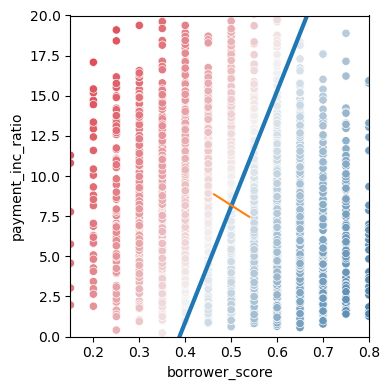

In [38]:
# Figure5-1 
# Use scalings and center of means to determine decisiion boundary
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# payment_inc_ration for borrower_score of 0 & 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis = 1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4,4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                   hue='default', data=lda_df,
                   palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                   ax=ax, legend=False)

ax.set_ylim(0,20)
ax.set_xlim(0.15,0.8)
ax.plot((x_0, x_20), (0,20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

# Logistic Regression

# Logistic Response Funciton and Logit

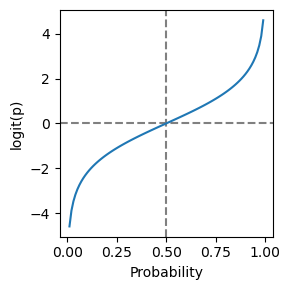

In [41]:
# Figure 5 - 2
p = np.arange(0.01,1,0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1-p)),
    'odds': p / (1-p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Probability')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

# Logistic Regression and the GLM

The package _scikit-learn_ has a specialised class for `LogisticRegression`. _Statsmodels_ have more general method based on generalized linear model (GLM). The arguments `penalty` and `C` are used to prevent overfitting by L1 and L2 regularization. Regularization is switched on by default. In order to fit without regularization, we set `C` to a very large value. The `solver` argument selects the used minimizer; the method `liblinear` is the default:

In [48]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_',
             'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='',
                  drop_first=True)
y = loan_data[outcome]

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]},
            index=X.columns)

intercept  -1.638088683407208
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079728
borrower_score,4.611037
debt_consolidation,-0.249342
home_improvement,-0.407614
major_purchase,-0.229376
medical,-0.510087
other,-0.620534
small_business,-1.215662
OWN,-0.048453
RENT,-0.157355


In [52]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

AttributeError: Can only use .cat accessor with a 'category' dtype

In [56]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('intercept', logit_reg_enc.intercept_[0])
print('classes', logit_reg_enc.classes_)
pd.DataFrame({'coeff': logit_reg_enc.coef_[0]},
            index=X.columns)

intercept 1.6380885435754573
classes [0. 1.]


,coeff
payment_inc_ratio,0.079728
borrower_score,-4.611037
debt_consolidation,0.249342
home_improvement,0.407614
major_purchase,0.229376
medical,0.510087
other,0.620534
small_business,1.215662
OWN,0.048453
RENT,0.157355
